## General function to clean up data from various grants

In [1]:
import _cleaning_utils
import _harmonization_utils as harmonization_utils
import _state_rail_plan_utils as srp_utils
import pandas as pd
from calitp_data_analysis.sql import to_snakecase

import shapely 
import geopandas as gpd

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/jovyan/data-analyses/project_list/_sb1_utils.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migrati

In [2]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [3]:
# sb1 = harmonization_utils.load_sb1()

In [4]:
# lost = harmonization_utils.load_lost()

In [5]:
# srp = harmonization_utils.load_state_rail_plan()

In [6]:
def harmonizing(
    df,
    agency_name: str,
    project_name: str,
    project_description: str,
    project_category: str,
    project_cost: str,
    location: str,
    county: str,
    city: str,
    project_year: str,
    program: str,
    fund_cols: list,
    cost_in_millions: bool = True,
):
    """
    Take a dataset and change the column names/types to
    default names and formats.

    Add metric if the project is fully funded or not.
    """
    # Rename columns
    rename_columns = {
        agency_name: "lead_agency",
        project_name: "project_title",
        project_description: "project_description",
        project_category: "project_category",
        project_cost: "total_project_cost",
        location: "location",
        county: "county",
        city: "city",
        project_year: "project_year",
    }

    df = df.rename(columns=rename_columns)

    # Coerce cost/fund columns to right type
    cost_columns = df.columns[df.columns.str.contains("(cost|funds)")].tolist()
    for i in cost_columns:
        df[i] = df[i].apply(pd.to_numeric, errors="coerce").fillna(0)

    # Clean up string columns
    string_cols = df.select_dtypes(include=["object"]).columns.to_list()
    for i in string_cols:
        df[i] = df[i].str.strip().str.title()

    # Clean agency names
    df = harmonization_utils.organization_cleaning(df, "lead_agency")

    # Add data source
    df["data_source"] = program

    # Divide cost columns by millions
    # If bool is set to True
    if cost_in_millions:
        for i in cost_columns:
            df[i] = df[i].divide(1_000_000)

    # Create columns even if they don't exist, just to harmonize
    # before concatting.
    if "county" not in df:
        df["county"] = "None"
    if "city" not in df:
        df["city"] = "None"
    if "notes" not in df:
        df["notes"] = "None"
    if "project_year" not in df:
        df["project_year"] = "None"
    if "project_category" not in df:
        df["project_category"] = "None"

    # Determine if the project completely funded or not?
    # Add up all available funds
    df["total_available_funds"] = df[fund_cols].sum(axis=1)

    # Compare if available funds is greater or equal to
    # total project cost
    df["fully_funded"] = df.apply(harmonization_utils.funding_vs_expenses, axis=1)

    # Only keep certain columns
    columns_to_keep = [
        "project_title",
        "lead_agency",
        "project_year",
        "project_category",
        "project_description",
        "total_project_cost",
        "fully_funded",
        "total_available_funds",
        "location",
        "county",
        "city",
        "notes",
        "data_source",
    ]
    df = df[columns_to_keep]

    # Fill in any nulls
    df = df.fillna(df.dtypes.replace({"float64": 0.0, "object": "None"}))

    return df

In [17]:
def add_all_projects():

    # Load original dataframes
    state_rail_plan = harmonization_utils.load_state_rail_plan()
    lost = harmonization_utils.load_lost()
    sb1 = harmonization_utils.load_sb1()

    # Clean dataframes
    state_rail_plan = harmonizing(
        state_rail_plan,
        agency_name="lead_agency",
        project_name="project_name",
        project_description="project_description",
        project_category="project_category",
        project_cost="total_project_cost",
        location="corridor",
        county="",
        city="",
        project_year="",
        program="State Rail Plan",
        fund_cols=[],
        cost_in_millions=True,
    )
    lost = harmonizing(
        lost,
        agency_name="agency",
         project_name = "project_title",
        project_description="project_description",
        project_category= "project_category",
         project_cost="cost__in_millions_",
        location = "location",
        county = "county",
        city = "city",
        project_year = "",
        program = "LOST",
        fund_cols = [
            "estimated_lost_funds",
            "estimated_federal_funds",
            "estimated_state_funds",
            "estimated_local_funds",
            "estimated_other_funds",
        ],
        cost_in_millions = False,
    )
    sb1 = harmonizing(
        sb1,
        agency_name="agencies",
        project_name="projecttitle_x",
        project_description="projectdescription",
        project_category="",
        project_cost="totalcost",
        location="geometry",
        county="countynames",
        city="citynames",
        project_year="fiscalyears",
        program="SB1",
        fund_cols=["sb1funds", "iijafunds"],
        cost_in_millions=True,
    )
    
    # Concat for df
    all_projects_df = pd.concat([lost, state_rail_plan, sb1])
    
    # Concat for gdf
    all_projects_gdf = pd.concat([sb1])
    all_projects_gdf = all_projects_gdf.set_geometry('location')
    
    return all_projects_df, all_projects_gdf

In [18]:
all_projects, all_projects_geo = add_all_projects()

/home/jovyan/data-analyses/project_list/_sb1_utils.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
/home/jovyan/data-analyses/project_list/_sb1_utils.py:35: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
/home/jovyan/data-analyses/project_list/_sb1_utils.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
/home/jovyan/data-analyses/project_list/_sb1_utils.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
/home/jovyan/data-analyses/project_list/_sb1_utils.py:35: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
/tmp/ipykernel_2374/3290

In [9]:
type(all_projects_geo)

geopandas.geodataframe.GeoDataFrame

<AxesSubplot:>

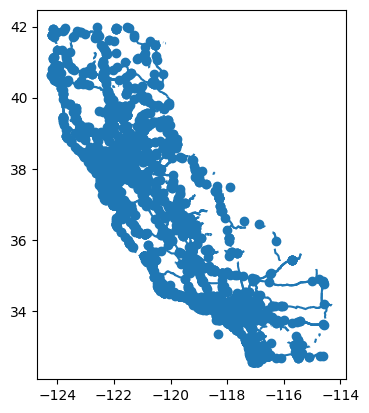

In [19]:
all_projects_geo.plot()

In [10]:
all_projects.shape

(8229, 13)

In [11]:
type(all_projects)

pandas.core.frame.DataFrame

In [12]:
all_projects.fully_funded.value_counts() / len(all_projects) * 100

No available funding info   44.65
Partially funded            28.13
Fully funded                13.99
No project cost info        13.23
Name: fully_funded, dtype: float64

In [13]:
all_projects.loc[all_projects.fully_funded == "Fully funded"].groupby(
    ["data_source"]
).agg({"total_project_cost": "median", "total_available_funds": "median"})

,total_project_cost,total_available_funds
data_source,,
LOST,7.61,7.61
SB1,1.29,1.31


In [14]:
all_projects.groupby(['fully_funded']).agg({'project_title':'count', 'total_project_cost':'median','total_available_funds':'median'})

,project_title,total_project_cost,total_available_funds
fully_funded,,,
Fully funded,1151,1.70,1.72
No available funding info,3674,3.85,0.00
No project cost info,1089,0.00,0.00
Partially funded,2315,8.46,1.82


In [23]:
all_projects.drop(columns = ['location']).sample(10)

,project_title,lead_agency,project_year,project_category,project_description,total_project_cost,fully_funded,total_available_funds,county,city,notes,data_source
4874,Collision Severity Reduction,Caltrans,22/23,None,A 1063 Million Dollar Project In Monterey County On Route 101 Will Lengthen The Onramp To Improve Merging Conflicts And Reduce The Number And Severity Of Collisions,10.63,Partially funded,6.92,Monterey,Salinas,Shopp/Sb1,SB1
1745,None,University Of California - Santa Cruz,"14/15, 18/19",None,None,1.93,Partially funded,0.80,Santa Cruz,Santa Cruz,Atp/Sb1,SB1
6,Us 101 Undercrossing Double Track And Siding,Multiple,None,Capital,Us 101 Undercrossing Double Track And Siding,50.00,No available funding info,0.00,None,None,None,State Rail Plan
40,Go-Stop Signaling System,Bnsf,None,Capital,"Upgrade The Corridor'S Existing 4-Aspect Signaling System To Go-Stop. Trains Not Exceeding 8,500 Ft, 100 Tob Can Run At 10 Minute Headways",17.50,No available funding info,0.00,None,None,None,State Rail Plan
1147,Facilities Hm5,Caltrans,20/21,None,In Los Angeles County This Project Will Maintainrepair Maintenance Station,0.24,No available funding info,0.00,Los Angeles,"Redondo Beach, Torrance",Hm/Sb1,SB1
153,Park Ave From Delta To Fern,None,None,None,Mainteneance,0.00,No project cost info,0.00,Imperial,City Of Calipatria,None,LOST
1155,Drainage,Caltrans,17/18,None,This Project Will Perform Preservation Activities On Approximately 6 Culverts On Route 330 In San Bernardino County,1.30,No available funding info,0.00,San Bernardino,None,Hm/Sb1,SB1
991,Rd 29 Olive To Ave 13,None,None,None,2 To 4 Lanes,4.86,Fully funded,28.11,Madera,None,None,LOST
230,Facilities,Caltrans,19/20,None,In City Of San Gabriel At San Gabriel Electrical Maintenance Stationa Remodel Existing Building To Meet The Current California Building Code,0.52,No available funding info,0.00,Los Angeles,Rosemead,Shopa/Sb1,SB1
6075,Pavement Rehabilitation,Caltrans,23/24,None,A 476 Million Dollar Project In Orange County On Route 91 Will Rehabilitate Pavement Rehabilitate Culverts Upgrade Lighting Upgrade Transportation Management System Tms Elements And Make Highway Worker Safety Improvementsg13 Contingency,4.76,Partially funded,0.56,Orange,"Anaheim, Orange",Shopp/Sb1,SB1


In [15]:
# all_projects_df = harmonization_utils.add_all_projects()